# The Movie Database

In [428]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lib.helper as Tmdb

In [429]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams["figure.figsize"] = [12, 8]

In [430]:
lang = pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_639-2_codes')
lang_codes = lang[1]
lang_codes.drop(['639-2[1]', '639-3[2]', '639-5[3]', 'Scope', 'Type', 'Native name(s)',
                     'Other name(s)'], axis=1, inplace=True)
lang_codes.dropna(inplace=True)

In [431]:
movies_df = Tmdb.get_movies(start_page=1,end_page=100)

In [432]:
movies_df.columns

Index(['adult', 'genre_ids', 'original_language', 'popularity', 'release_date',
       'title', 'budget', 'revenue', 'production_companies',
       'production_countries', 'runtime'],
      dtype='object')

In [433]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1980 entries, 0 to 1979
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 1980 non-null   bool   
 1   genre_ids             1980 non-null   object 
 2   original_language     1980 non-null   object 
 3   popularity            1980 non-null   float64
 4   release_date          1980 non-null   object 
 5   title                 1980 non-null   object 
 6   budget                1980 non-null   int64  
 7   revenue               1980 non-null   int64  
 8   production_companies  1980 non-null   object 
 9   production_countries  1980 non-null   object 
 10  runtime               1980 non-null   int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 156.8+ KB


In [434]:
movies_df.describe()

,popularity,budget,revenue,runtime
count,1980.000000,1.980000e+03,1.980000e+03,1980.000000
mean,97.480871,4.346960e+07,1.663918e+08,106.112121
std,209.811563,6.350188e+07,2.903123e+08,29.559825
min,36.397000,0.000000e+00,0.000000e+00,0.000000
25%,48.282000,0.000000e+00,0.000000e+00,92.000000
50%,60.104500,1.292550e+07,3.445918e+07,105.000000
75%,87.841000,6.500000e+07,2.139727e+08,121.000000
max,6334.004000,4.600000e+08,2.923706e+09,242.000000


In [435]:
movies_df.head()

,adult,genre_ids,original_language,popularity,release_date,title,budget,revenue,production_companies,production_countries,runtime
0,False,"[28, 35, 878]",en,6334.004,2024-07-24,Deadpool & Wolverine,200000000,1147848023,"[Marvel Studios, Maximum Effort, 21 Laps Enter...",[United States of America],128
1,False,"[16, 10751, 12, 35]",en,3413.374,2024-06-11,Inside Out 2,200000000,1625983694,"[Walt Disney Pictures, Pixar]",[United States of America],97
2,False,"[28, 12, 18, 53]",en,2373.617,2024-07-10,Twisters,155000000,333439315,"[Universal Pictures, Warner Bros. Pictures, Am...",[United States of America],123
3,False,"[16, 10751, 35, 28]",en,2163.327,2024-06-20,Despicable Me 4,100000000,847329715,"[Universal Pictures, Illumination]",[United States of America],94
4,False,"[28, 80, 53, 35]",en,1840.966,2024-06-05,Bad Boys: Ride or Die,100000000,400124003,"[Westbrook, Columbia Pictures, Don Simpson/Jer...",[United States of America],115


## Preprocessing for EDA

In [436]:
from sklearn.base import BaseEstimator, TransformerMixin

In [437]:
class BaseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['original_language'] = X['original_language']\
            .transform(lambda x: Tmdb.lang_transform(x, lang_codes))
        X['genre'] = X['genre_ids'].transform(lambda x: Tmdb.genre_transform(x))
        X['revenue(mil)'] = X['revenue'].apply(lambda x: x / 1000000)
        X['budget(mil)'] = X['budget'].apply(lambda x: x / 1000000)
        X['release_date'] = pd.to_datetime(X['release_date'])
        X['month'] = X['release_date'].dt.strftime('%b')
        month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        X['month'] = pd.Categorical(X['month'], categories=month_label, ordered=True)
        return X
    


In [438]:
class TypeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X['runtime(min)'] = X['runtime'].astype('float')
        X['adult'] = X['adult'].astype('category') 
        return X

In [439]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.loc[(X['revenue(mil)'] > 0) & (X['budget(mil)'] > 0)]
        return X.drop(['genre_ids', 'budget','revenue','runtime'], axis=1, errors="ignore")

In [440]:
from sklearn.pipeline import Pipeline

pipline = Pipeline([('transform', BaseTransformer()),
                    ('type', TypeTransformer()),
                    ('dropper', FeatureDropper())])

In [441]:
processed_eda_df = pipline.fit_transform(movies_df)

## Exploratory Data Analysis

In [442]:
processed_eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, 0 to 1978
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   adult                 1213 non-null   category      
 1   original_language     1213 non-null   object        
 2   popularity            1213 non-null   float64       
 3   release_date          1213 non-null   datetime64[ns]
 4   title                 1213 non-null   object        
 5   production_companies  1213 non-null   object        
 6   production_countries  1213 non-null   object        
 7   genre                 1213 non-null   object        
 8   revenue(mil)          1213 non-null   float64       
 9   budget(mil)           1213 non-null   float64       
 10  month                 1213 non-null   category      
 11  runtime(min)          1213 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(4), object(5)
memory usage: 107.1+ KB


In [443]:
processed_eda_df.head()

,adult,original_language,popularity,release_date,title,production_companies,production_countries,genre,revenue(mil),budget(mil),month,runtime(min)
0,False,English,6334.004,2024-07-24,Deadpool & Wolverine,"[Marvel Studios, Maximum Effort, 21 Laps Enter...",[United States of America],"[Action, Comedy, Science Fiction]",1147.848023,200.0,Jul,128.0
1,False,English,3413.374,2024-06-11,Inside Out 2,"[Walt Disney Pictures, Pixar]",[United States of America],"[Adventure, Animation, Comedy, Family]",1625.983694,200.0,Jun,97.0
2,False,English,2373.617,2024-07-10,Twisters,"[Universal Pictures, Warner Bros. Pictures, Am...",[United States of America],"[Action, Adventure, Drama, Thriller]",333.439315,155.0,Jul,123.0
3,False,English,2163.327,2024-06-20,Despicable Me 4,"[Universal Pictures, Illumination]",[United States of America],"[Action, Animation, Comedy, Family]",847.329715,100.0,Jun,94.0
4,False,English,1840.966,2024-06-05,Bad Boys: Ride or Die,"[Westbrook, Columbia Pictures, Don Simpson/Jer...",[United States of America],"[Action, Comedy, Crime, Thriller]",400.124003,100.0,Jun,115.0


In [444]:
grp_yr = processed_eda_df.groupby(processed_eda_df.loc[(processed_eda_df['release_date'].dt.year >= 2010),'release_date'].dt.year)

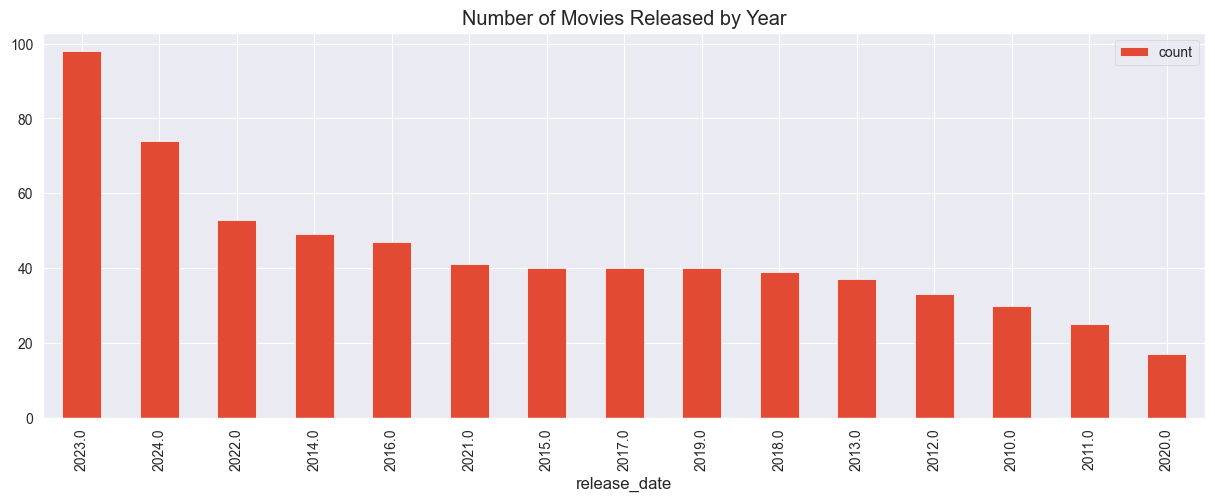

In [445]:
grp_yr['title'].size().reset_index(name='count').sort_values('count', ascending=False).plot(kind='bar', x='release_date', y='count', figsize=(15, 5), title='Number of Movies Released by Year')
plt.show()

In [446]:
group_year_sum = grp_yr[['revenue(mil)', 'budget(mil)']].sum().reset_index()
group_year_mean = grp_yr[['revenue(mil)', 'budget(mil)']].mean().reset_index()

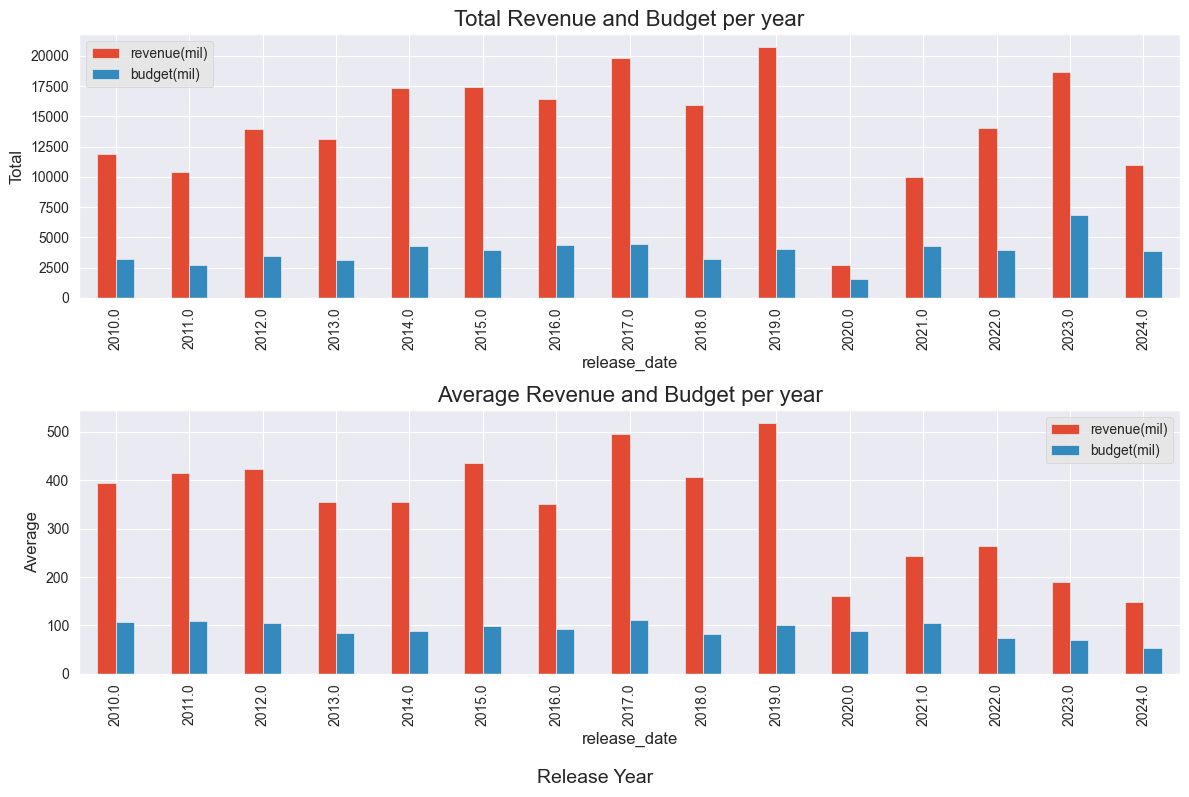

In [447]:
fig, (ax1, ax2) = plt.subplots(2)
plt.style.use('ggplot')
fig.supxlabel('Release Year', fontsize=14)

ax1.set_title('Total Revenue and Budget per year', fontsize=16)
group_year_sum.plot(x='release_date', kind='bar', ax=ax1)
ax1.set_ylabel("Total")

ax2.set_title('Average Revenue and Budget per year', fontsize=16)
group_year_mean.plot(x='release_date', kind='bar', ax=ax2)
ax2.set_ylabel('Average')

plt.tight_layout()
plt.show()

### Total Revenue and Budget per Year

- This plot displays the total revenue and budget for movies released each year, starting from the year 2010.
- The x-axis represents the years, while the y-axis represents the total revenue and budget in millions of dollars.
- Each bar represents a year, with two bars side by side for each year, one representing the total revenue and the other representing the total budget.
- This plot provides an overview of the overall financial performance of movies released each year, allowing us to identify trends and fluctuations in revenue and budget over time.

### Average Revenue and Budget per Year

- This plot illustrates the average revenue and budget for movies released each year, starting from the year 2010.
- Similar to the previous plot, the x-axis represents the years, while the y-axis represents the average revenue and budget in millions of dollars.
- Each bar represents a year, with two bars side by side for each year, one representing the average revenue and the other representing the average budget.
- Unlike the previous plot, which shows the total financial figures, this plot focuses on the average financial performance per movie released each year.
- By examining the average revenue and budget trends over time, we can gain insights into the profitability and investment patterns in the movie industry.


In [448]:
grp_month = processed_eda_df.groupby('month', observed=False)

In [449]:
group_month_sum = grp_month[['revenue(mil)', 'budget(mil)']].sum().reset_index()
group_month_mean = grp_month[['revenue(mil)', 'budget(mil)']].mean().reset_index()

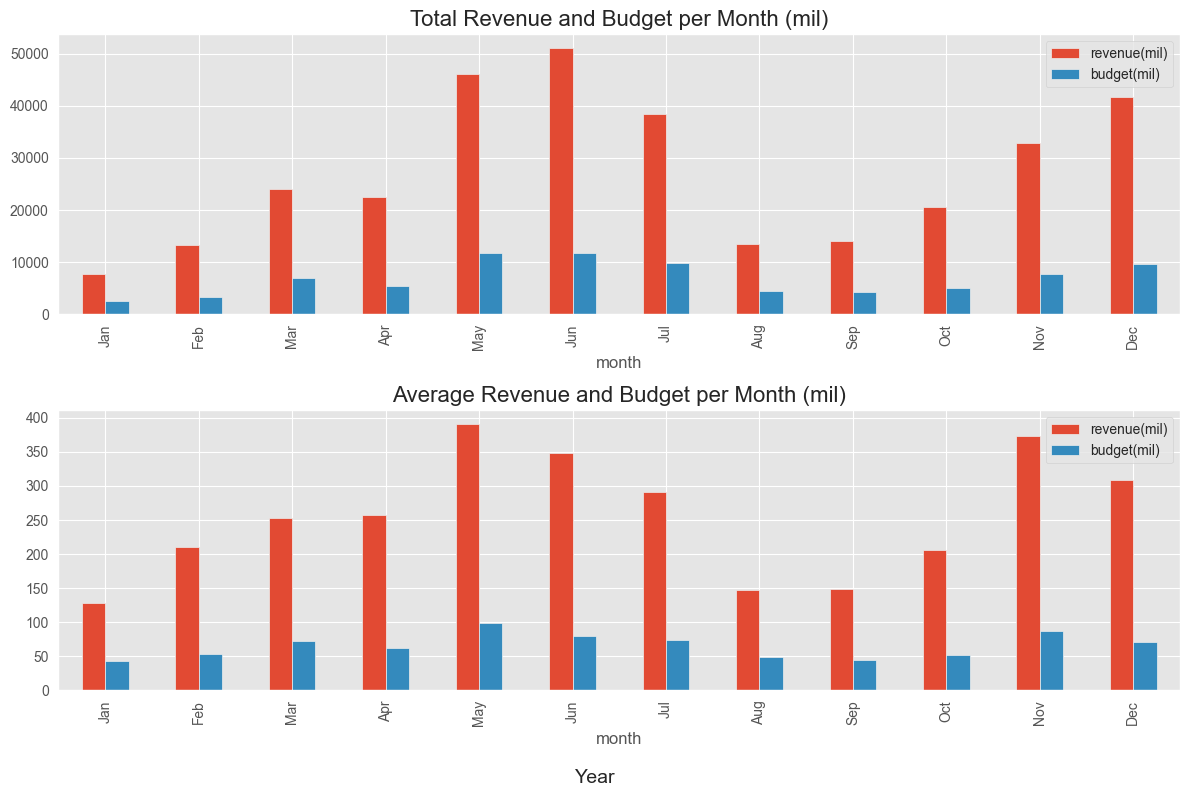

In [450]:
fig, (ax1, ax2) = plt.subplots(2)

plt.style.use('ggplot')
fig.supxlabel('Year', fontsize=14)

ax1.set_title('Total Revenue and Budget per Month (mil)', fontsize=16)
group_month_sum.plot(x='month', kind='bar', ax=ax1)

ax2.set_title('Average Revenue and Budget per Month (mil)', fontsize=16)
group_month_mean.plot(x='month', kind='bar', ax=ax2)
plt.tight_layout()
plt.show()

### Total Revenue and Budget per Month

- This plot displays the total revenue and budget for movies released each month.
- The x-axis represents the months of the year, while the y-axis represents the total revenue and budget in millions of dollars.
- Each bar represents a month, with two bars side by side for each month, one representing the total revenue and the other representing the total budget.
- This plot provides an overview of the financial performance of movies released each month, allowing us to identify patterns and trends in revenue and budget allocation throughout the year.

### Average Revenue and Budget per Month

- This plot illustrates the average revenue and budget for movies released each month.
- Similar to the previous plot, the x-axis represents the months of the year, while the y-axis represents the average revenue and budget in millions of dollars.
- Each bar represents a month, with two bars side by side for each month, one representing the average revenue and the other representing the average budget.
- Unlike the previous plot, which shows the total financial figures, this plot focuses on the average financial performance per movie released each month.
- By examining the average revenue and budget trends over each month, we can gain insights into the seasonality and periodic patterns in movie revenues and budget allocations.




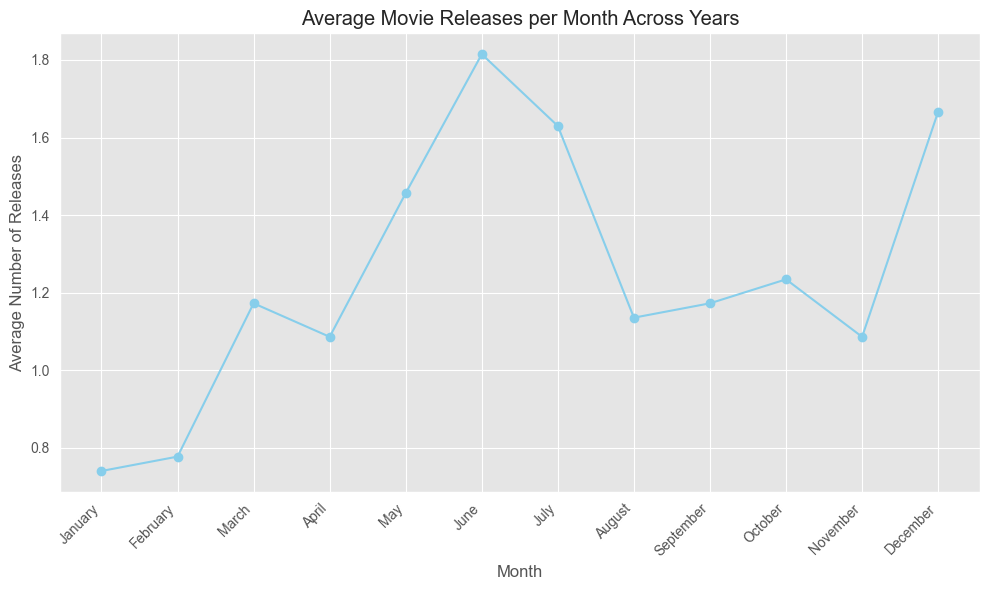

In [451]:
monthly_release_avg = processed_eda_df.groupby([processed_eda_df['release_date'].dt.year,'month']).size().groupby(['month']).mean()

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(10, 6))
plt.plot(months, monthly_release_avg, marker='o', color='skyblue', linestyle='-')
plt.title('Average Movie Releases per Month Across Years')
plt.xlabel('Month')
plt.ylabel('Average Number of Releases')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analysis of Seasonal Trends in Movie Releases

- The provided plot reveals interesting insights into the seasonal patterns of movie releases.
- There are noticeable spikes in movie releases around May, June, and July, which can be attributed to the abundance of holidays during the summer months.
- Another significant spike occurs around November and December, coinciding with the Christmas and year-end holidays.
- This observation suggests that production companies strategically time the release of movies to coincide with seasonal changes and holiday periods, aiming to capitalize on increased leisure time and consumer spending during these periods.
- By aligning movie releases with holidays and seasonal changes, production companies can maximize audience engagement and box office revenue.
- The plot below effectively illustrates the average release of movies per month across multiple years, providing valuable insights into the temporal distribution of movie releases and underlying industry strategies.

<Axes: >

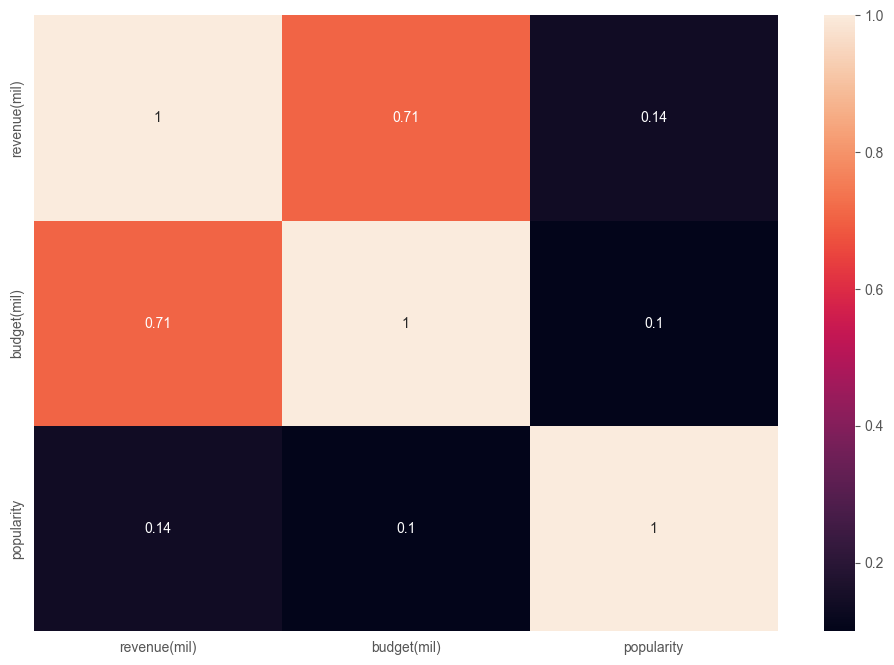

In [452]:
sns.heatmap(processed_eda_df[['revenue(mil)', 'budget(mil)','popularity']].corr(), annot=True)

### Correlation Heatmap

- This heatmap illustrates the correlation matrix between various numerical features in the dataset.
- The heatmap color-codes the correlation coefficients, with warmer colors indicating stronger positive correlations and cooler colors indicating stronger negative correlations.
- The annotations on the heatmap represent the correlation coefficients, providing quantitative insights into the strength and direction of relationships between pairs of features.
- By examining the correlations between features such as revenue, budget, vote average, popularity, and vote count, we can identify potential relationships and dependencies within the dataset.
- Understanding these correlations can help inform further analysis and modeling decisions, such as feature selection and model interpretation.
- It shows a strong relationship between our target variable (revenue) with vote count and budget, although budget is expected vote count is expected to show a relationship, 
- it also reveals that the popularity of a movie is linked to its revenue or budget

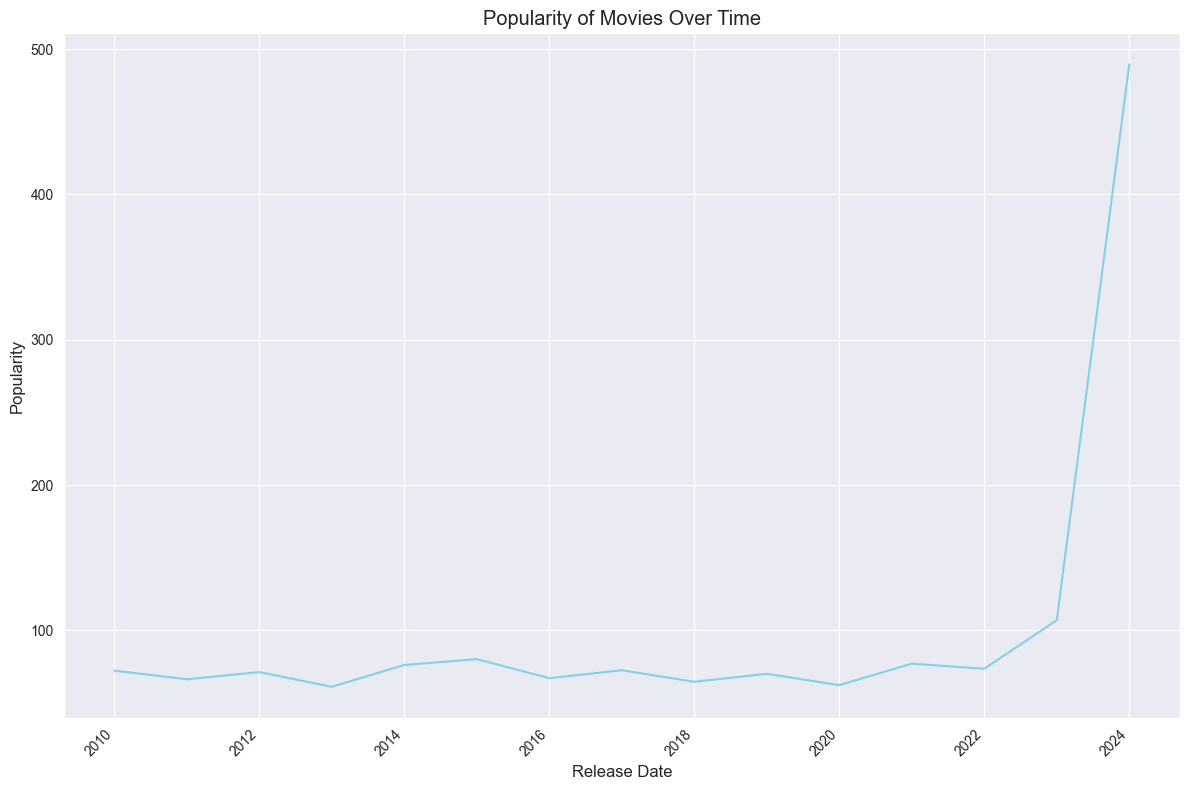

In [485]:
popularity_over_time = grp_yr['popularity'].mean()

plt.plot(popularity_over_time.index, popularity_over_time.values, color='skyblue')
plt.title('Popularity of Movies Over Time')
plt.xlabel('Release Date')
plt.ylabel('Popularity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Analysis of Popularity Trend Over Time

- The plotted data illustrates the average popularity of movies over time, aggregated on a yearly basis.
- Upon examination, there is a noticeable spike in movie popularity around the year 2024.
- This spike suggests a significant increase in audience interest and engagement with movies released during that period.
- Possible factors contributing to this spike could include the release of highly anticipated movies, breakthrough performances, or innovative marketing strategies.
- The observed spike in movie popularity around 2024 may reflect shifting audience preferences, industry trends, or cultural influences during that time.
- Further analysis, including examining specific movie releases and external events occurring around 2024, could provide additional insights into the drivers behind this popularity surge.
- Overall, this visualization offers valuable insights into the temporal dynamics of movie popularity, highlighting notable trends and fluctuations over time.


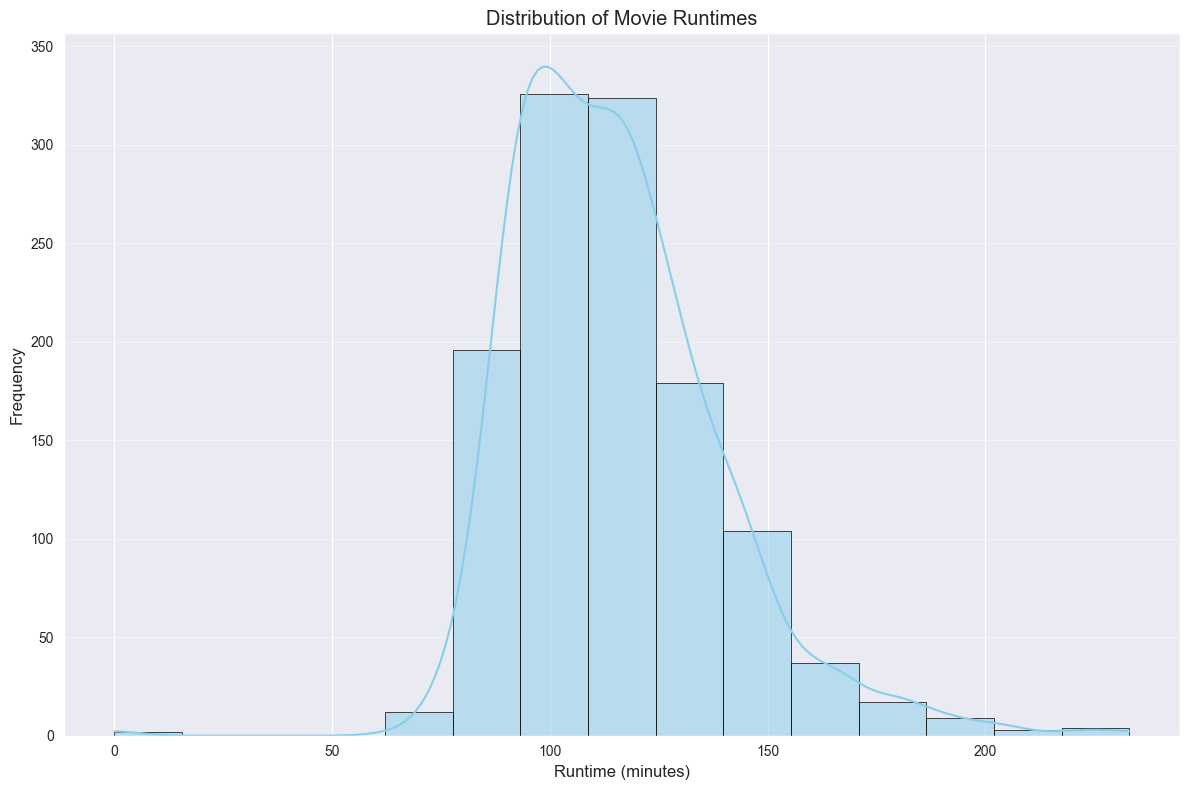

In [486]:
sns.histplot(processed_eda_df['runtime(min)'], bins=15, color='skyblue', edgecolor='black', kde=True)
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

### Analysis of Movie Runtime Distribution

- The histogram visualizes the distribution of movie runtimes, measured in minutes.
- Upon examination, the distribution appears to be unimodal, with a peak in frequency observed between 100 and 120 minutes.
- This indicates that a significant proportion of movies in the dataset have runtime durations falling within this range.
- Conversely, there is a notable decrease in frequency observed for movies with runtime durations exceeding 160 minutes, suggesting fewer movies have longer durations beyond this threshold.
- The histogram's shape and peaks provide insights into the typical runtime preferences within the dataset, with most movies falling within a certain duration range.
- Understanding the distribution of movie runtimes can inform various aspects of movie production and consumption, such as scheduling, audience preferences, and content pacing.
- Further analysis, such as exploring runtime trends across genres or release years, could provide additional insights into factors influencing movie runtime distribution.


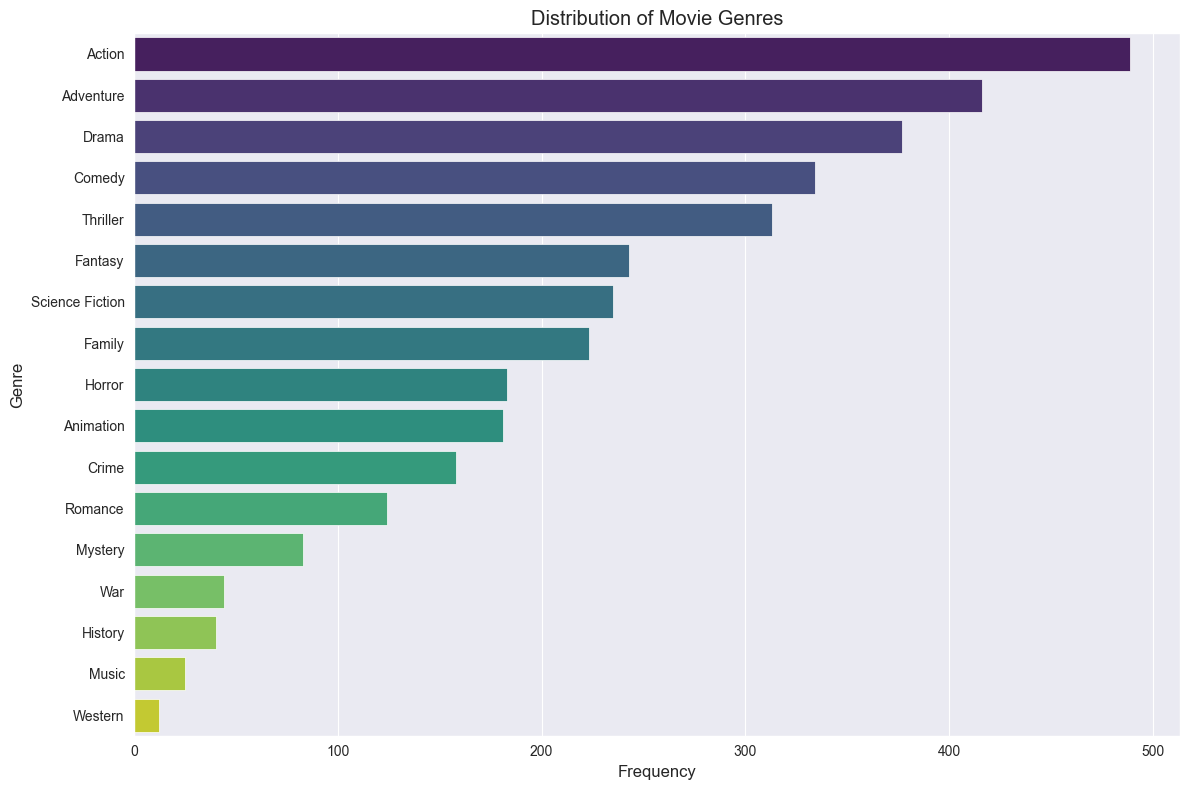

In [487]:
genres = [genre for sublist in processed_eda_df['genre'] for genre in sublist]

genre_counts = pd.Series(genres).value_counts()

sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis', hue=genre_counts.index, legend=False)
plt.title('Distribution of Movie Genres')
plt.xlabel('Frequency')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


### Analysis of Movie Genre Distribution

- The bar plot illustrates the distribution of movie genres based on their frequency of occurrence in the dataset.
- Upon inspection, the most prevalent genre is 'Action', with the highest frequency of occurrence.
- Following 'Action', the next most common genres are 'Adventure' and 'Drama', which also exhibit relatively high frequencies.
- 'Comedy' is another prevalent genre, ranking among the top genres in terms of frequency.
- In contrast, 'Western' emerges as the least common genre, with the lowest frequency of occurrence in the dataset.
- 'Music' and 'History' genres also have relatively low frequencies compared to other genres.
- Understanding the distribution of movie genres can provide insights into audience preferences, industry trends, and market demand for different types of content.
- These insights can inform various aspects of movie production, marketing, and distribution strategies tailored to specific genre preferences and audience segments.
- with access to a more detailed database that shows the countries of release, one can understand the distribution of genres across multiple countries

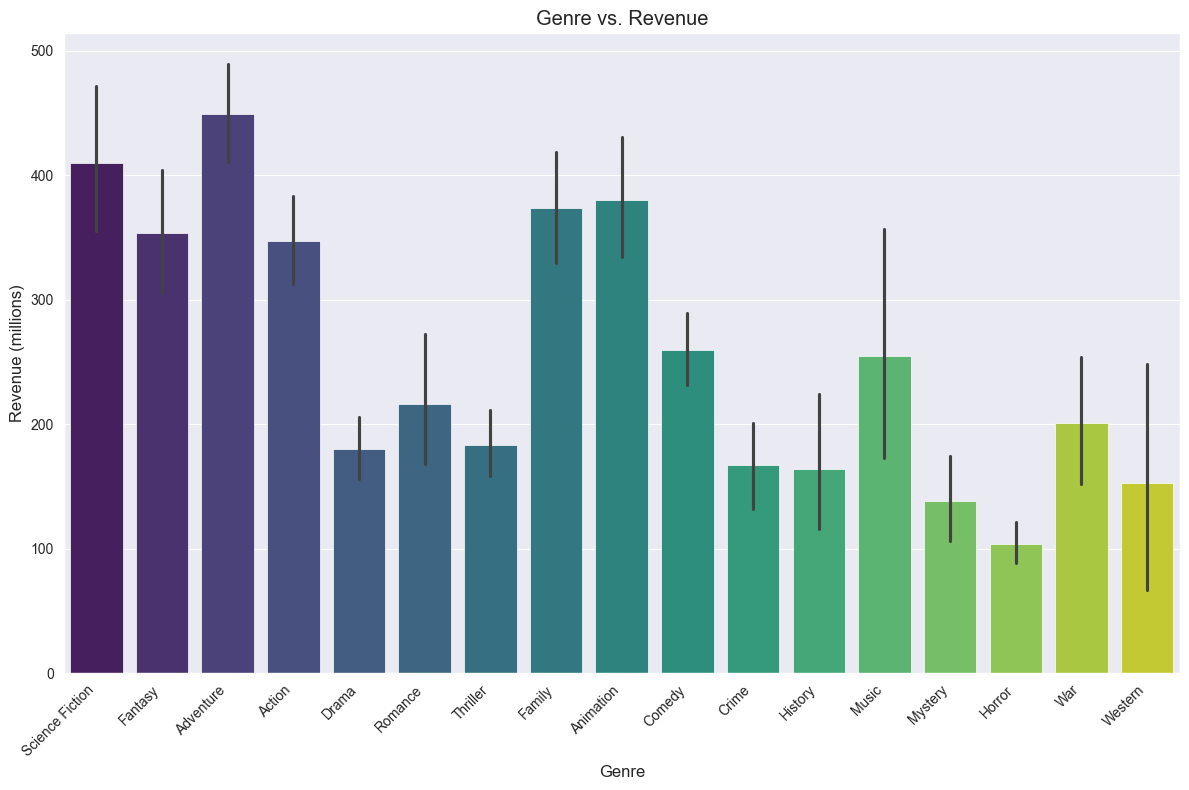

In [488]:
genres = [genre for sublist in processed_eda_df['genre'] for genre in sublist]
data = {'Genre': genres, 'Revenue (mil)': processed_eda_df['revenue(mil)'].repeat(processed_eda_df['genre'].str.len())}

genre_revenue_df = pd.DataFrame(data).sort_values(by='Revenue (mil)', ascending=False)

sns.set_style('darkgrid')
sns.barplot(data=genre_revenue_df, x='Genre', y='Revenue (mil)', palette='viridis', hue='Genre', legend=False)
plt.title('Genre vs. Revenue')
plt.xlabel('Genre')
plt.ylabel('Revenue (millions)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Analysis of Genre vs. Revenue

- The bar plot compares different movie genres based on their corresponding revenue generated, represented in millions of dollars.
- Upon inspection, 'Adventure' emerges as the genre with the highest revenue, indicating that movies categorized under this genre tend to generate significant financial returns.
- Following 'Adventure', 'Sci-Fi' and 'Family' genres also exhibit relatively high revenue figures, suggesting their popularity and profitability in the movie industry.
- 'Animation' and 'Fantasy' genres closely follow, further underscoring the commercial success of movies within these genres.
- Interestingly, although 'Action' was identified as one of the most prevalent genres, it does not rank highest in terms of revenue, highlighting a potential discrepancy between popularity and financial performance.
- This analysis sheds light on the varying revenue potentials associated with different movie genres, providing insights into audience preferences, market demand, and commercial viability within the entertainment industry.
- Understanding the relationship between genre and revenue can inform strategic decisions related to content production, marketing strategies, and investment opportunities in the movie sector.


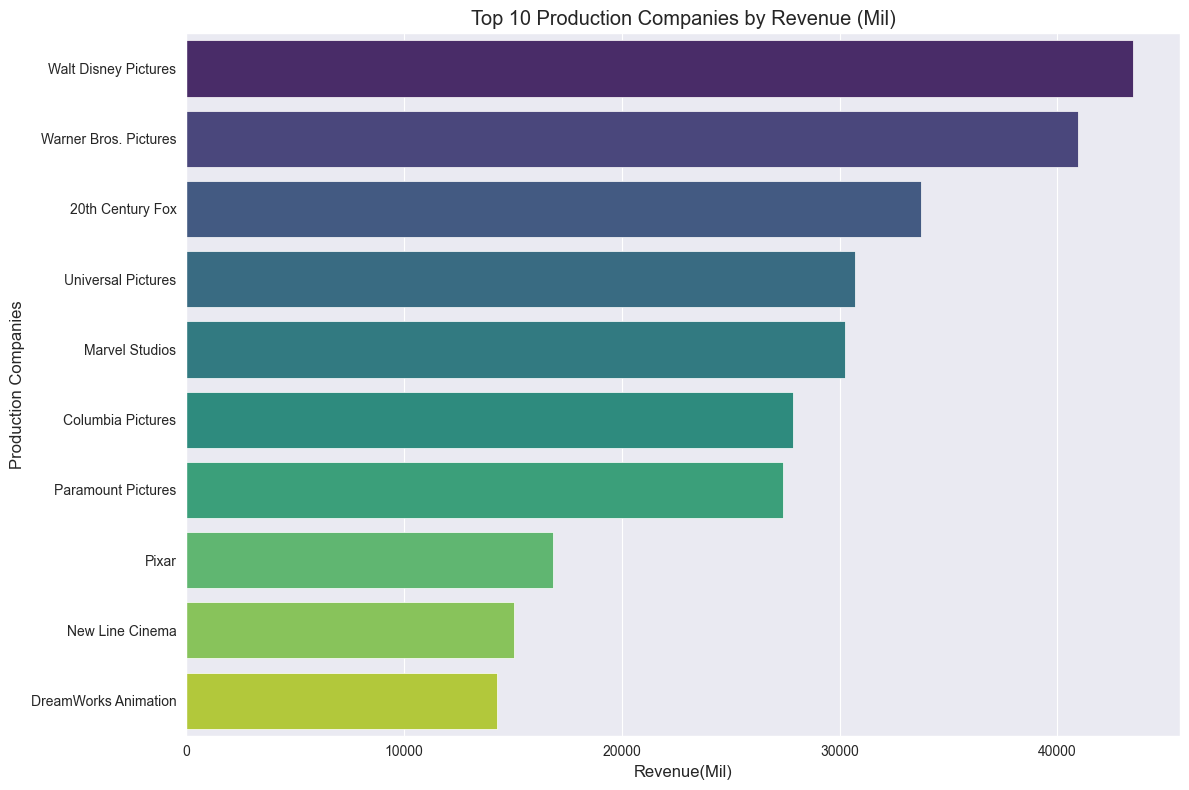

In [489]:
production_companies = [
    genre for sublist in processed_eda_df["production_companies"] for genre in sublist
]

data = {
    "PC": production_companies,
    "Revenue (mil)": processed_eda_df["revenue(mil)"].repeat(
        processed_eda_df["production_companies"].str.len()
    ),
}

top_10_pC = (
    pd.DataFrame(data).sort_values(by="Revenue (mil)", ascending=False).reset_index()
)
top_10 = top_10_pC.groupby(["PC"])["Revenue (mil)"].sum().reset_index(name="revenue").sort_values(
    by="revenue", ascending=False
).head(10)

sns.barplot(
    data=top_10,
    x='revenue',
    y='PC',
    palette="viridis",
    hue='PC',
    legend=False,
)
plt.title("Top 10 Production Companies by Revenue (Mil)")
plt.xlabel("Revenue(Mil)")
plt.ylabel("Production Companies")
plt.tight_layout()
plt.show()

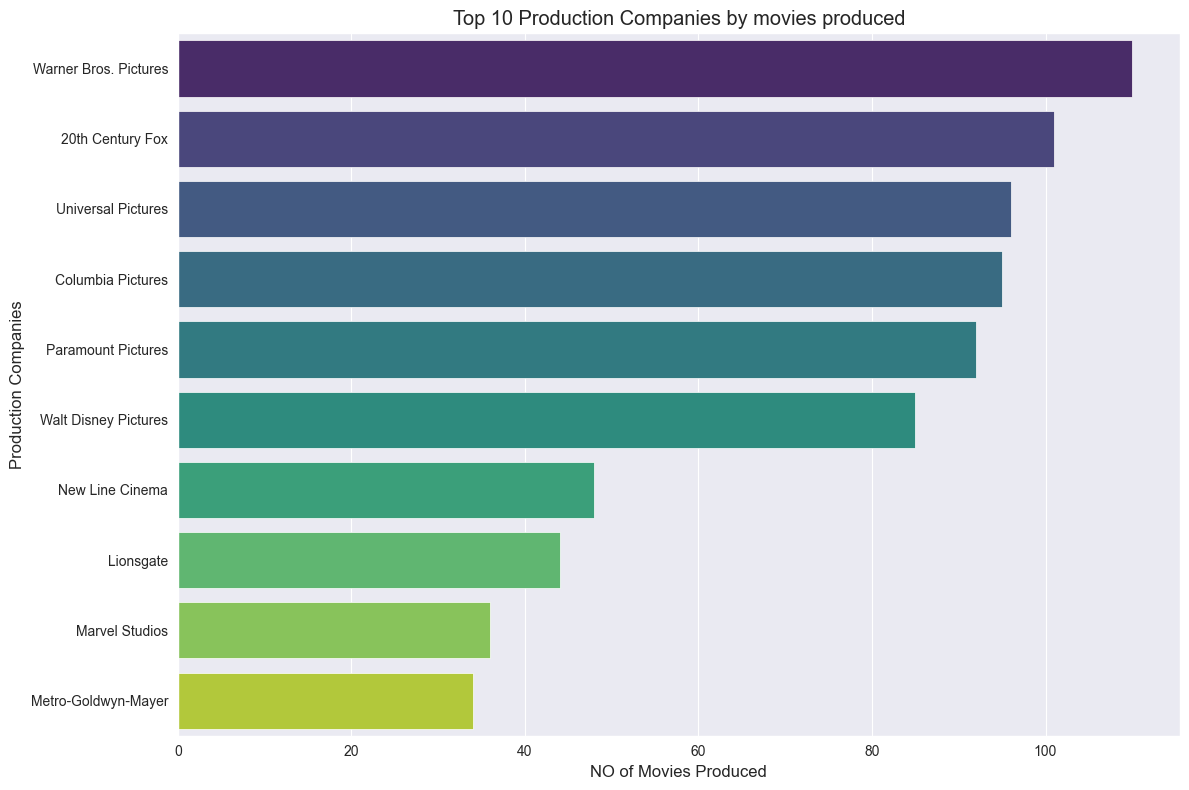

In [490]:
production_companies = [pc for sublist in processed_eda_df['production_companies'] for pc in sublist]

production_companies_counts = pd.Series(production_companies).value_counts()
top_10_pC = production_companies_counts.sort_values(ascending=False).head(10)

sns.barplot(x=top_10_pC.values, y=top_10_pC.index, palette='viridis', hue=top_10_pC.index, legend=False)
plt.title('Top 10 Production Companies by movies produced')
plt.xlabel('NO of Movies Produced')
plt.ylabel('Production Companies')
plt.tight_layout()
plt.show()

### Analysis of Top 10 Production Companies by Movies Produced

- The bar plot displays the top 10 production companies ranked by the number of movies they have produced.
- Upon examination, 'Warner Bros' emerges as the leading production company, with the highest number of movies produced among the top 10.
- Following 'Warner Bros', other prominent production companies include 'Columbia Pictures', 'Universal Pictures', 'Paramount Pictures', and '20th Century Fox', which also have significant numbers of movies in their portfolios.
- Notably, 'Walt Disney Pictures' also ranks among the top production companies, highlighting its substantial contribution to the movie industry.
- The ranking of production companies based on the number of movies produced provides insights into their production output and market influence within the industry.
- Understanding the dominance of certain production companies can inform strategic partnerships, distribution agreements, and investment decisions within the movie industry landscape.


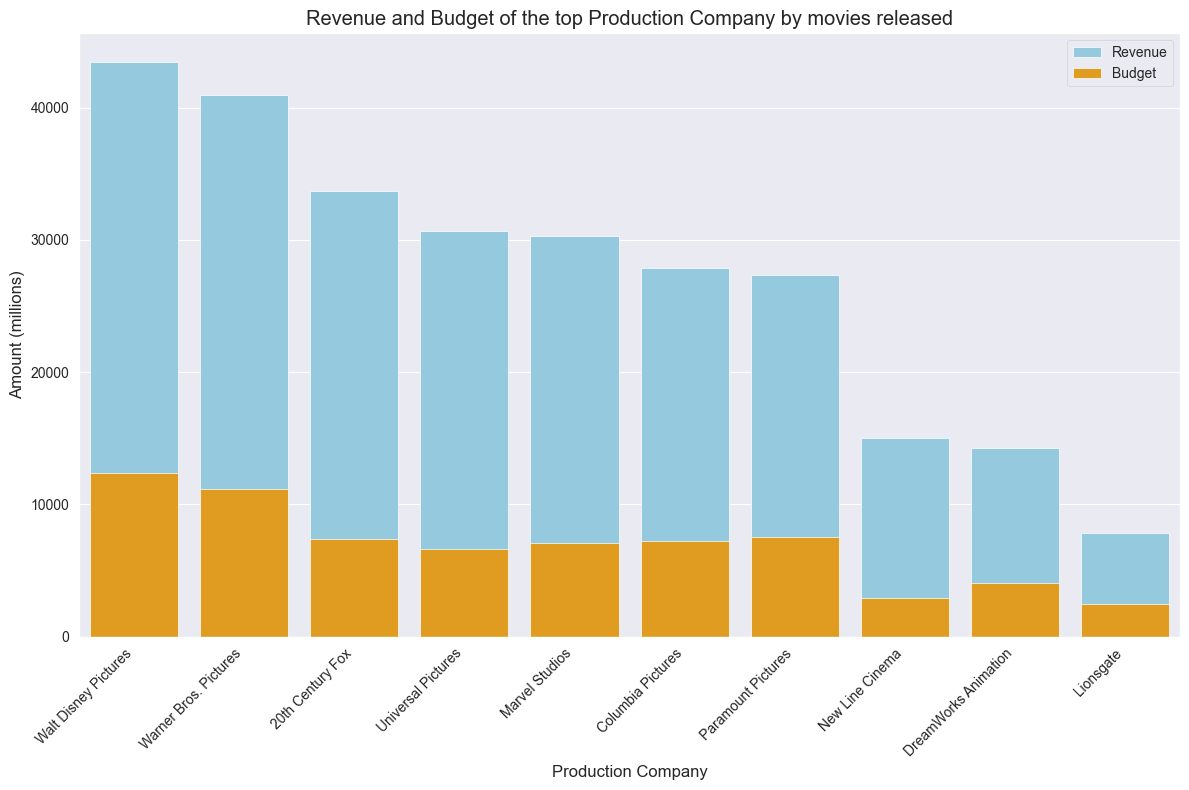

In [491]:
production_companies = [company for sublist in processed_eda_df['production_companies'] for company in sublist]

data = {'Production Company': production_companies, 'Revenue (mil)': processed_eda_df['revenue(mil)'].repeat(processed_eda_df['production_companies'].str.len()), 'Budget (mil)': processed_eda_df['budget(mil)'].repeat(processed_eda_df['production_companies'].str.len()), 'title': processed_eda_df['title'].repeat(processed_eda_df['production_companies'].str.len())}
production_df = pd.DataFrame(data)

production_agg = production_df.groupby('Production Company').agg({'Revenue (mil)': 'sum', 'Budget (mil)': 'sum', 'title':'count'}).reset_index().rename(columns={'title':'total movies'})
top_10_pC_by_movies = production_agg.sort_values(by='total movies', ascending=False).head(10)

sns.barplot(data=top_10_pC_by_movies.sort_values(by='Revenue (mil)', ascending=False) , x='Production Company', y='Revenue (mil)', color='skyblue', label='Revenue')
sns.barplot(data=top_10_pC_by_movies.sort_values(by='Revenue (mil)', ascending=False) , x='Production Company', y='Budget (mil)', color='orange', label='Budget')

plt.title('Revenue and Budget of the top Production Company by movies released')
plt.xlabel('Production Company')
plt.ylabel('Amount (millions)')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


### Analysis of Revenue and Budget of Top Production Companies by Movies Released

- The grouped bar plot compares the revenue and budget of the top production companies based on the number of movies they have released.
- The top production companies are determined by the total count of movies they have produced, highlighting their prominence in the industry.
- Each production company is represented by two bars: one indicating the total revenue generated by their movies, and the other representing the total budget allocated for their movie productions.
- Upon inspection, it is evident that certain top production companies, such as 'Warner Bros', 'Columbia Pictures', and 'Universal Pictures', exhibit substantial differences between their total revenue and budget figures.
- 'Warner Bros' stands out as the top production company in terms of both revenue and budget, indicating its significant financial success and investment capacity in the movie industry.
- This analysis offers insights into the financial performance and investment strategies of top production companies, providing valuable information for stakeholders in the movie production and distribution ecosystem.
- Understanding the revenue and budget dynamics of production companies can inform strategic decisions related to partnerships, investment opportunities, and resource allocation within the entertainment industry.


In [460]:
processed_eda_df.to_csv('../data/movies.csv', index=False)

# What Months do top companies release movies?

In [461]:
all_production_companies = [
    pc for sublist in processed_eda_df["production_companies"] for pc in sublist
]
data = {
    "PC": all_production_companies,
    "Revenue (mil)": processed_eda_df["revenue(mil)"].repeat(
        processed_eda_df["production_companies"].str.len()
    ),
    "Title": processed_eda_df["title"].repeat(
        processed_eda_df["production_companies"].str.len()
    ),
    "Month": processed_eda_df["month"].repeat(
        processed_eda_df["production_companies"].str.len()
    ),
}

top_10_pC = pd.DataFrame(data).sort_values(by="Revenue (mil)", ascending=False).reset_index()
count_per_month = top_10_pC.groupby(['PC','Month'])['Title'].count().unstack(level=1)
top_10_ = top_10_pC.groupby('PC')['Revenue (mil)'].sum().reset_index(name='Revenue (mil)').sort_values('Revenue (mil)', ascending=False).head(10)
top_10_with_month_count = top_10_.merge(count_per_month.reset_index(), on='PC')

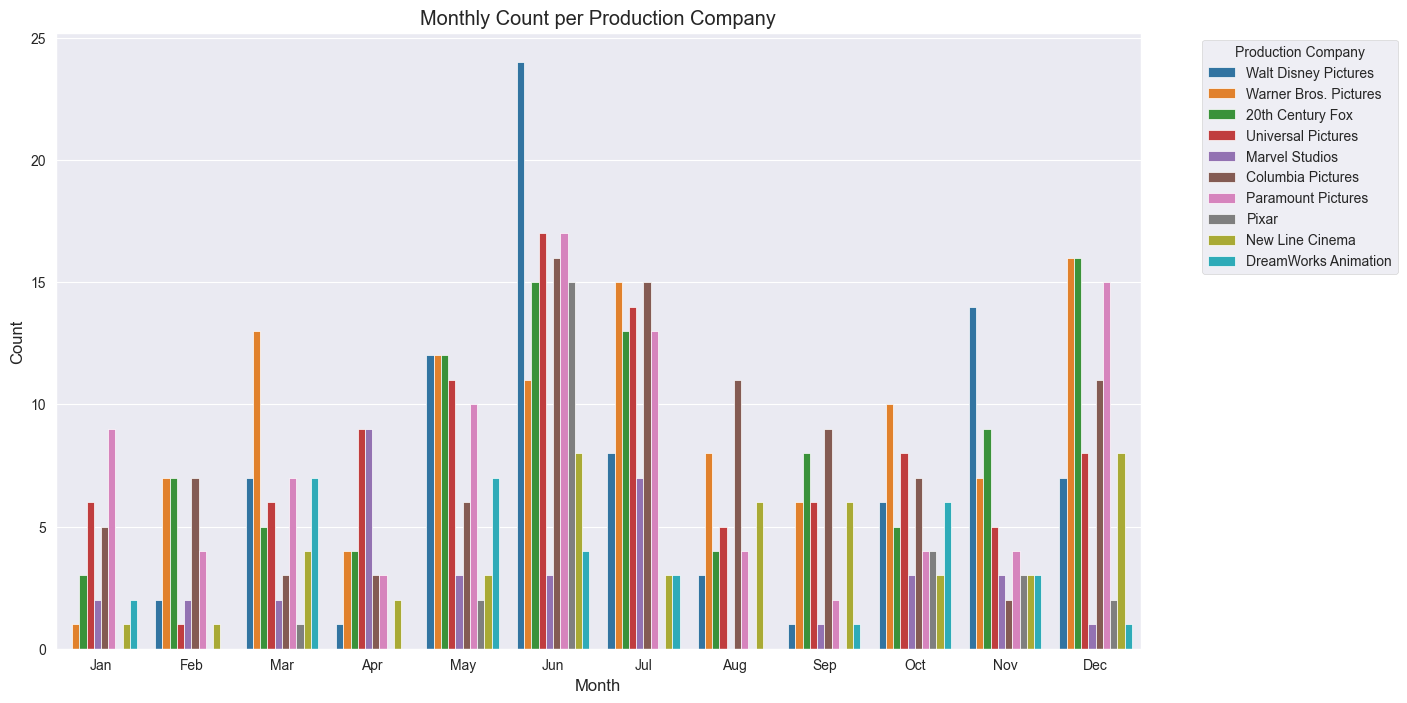

In [462]:
df_melted = top_10_with_month_count.melt(
    id_vars=["PC", "Revenue (mil)"], var_name="Month", value_name="Count"
)
plt.figure(figsize=(14, 8))
sns.barplot(data=df_melted, x="Month", y="Count", hue="PC", palette="tab10")

# Customize the plot
plt.title("Monthly Count per Production Company")
plt.xlabel("Month")
plt.ylabel("Count")
plt.legend(title="Production Company", bbox_to_anchor=(1.05, 1), loc="upper left")

# Show the plot
plt.show()

Top Companies tend to release more movies around June and July which can relate to those months being `Summer` months, and also Dec for its global holidays hence, draw more profit 
## Analysis:
### June and July (Summer Months):
- Increased Movie Releases: Many top companies release blockbuster movies during these months, capitalizing on school vacations and the general public’s leisure time.
- Strategic Releases: The weather, combined with long daylight hours and time off work or school, makes summer an ideal time for movie outings. Major studios often release their most anticipated films in June and July to maximize profits.
### December (Global Holidays):

- Holiday Season: December is another peak period for movie releases due to global holidays like Christmas and New Year’s. Family gatherings and holiday breaks provide ample opportunity for people to visit theaters.
- High-Profile Releases: Studios frequently schedule the release of family-friendly films and Oscar contenders during December to take advantage of the holiday season's boost in movie-going and to ensure that their films are fresh in the minds of awards voters.

# What Genere is usually longer?

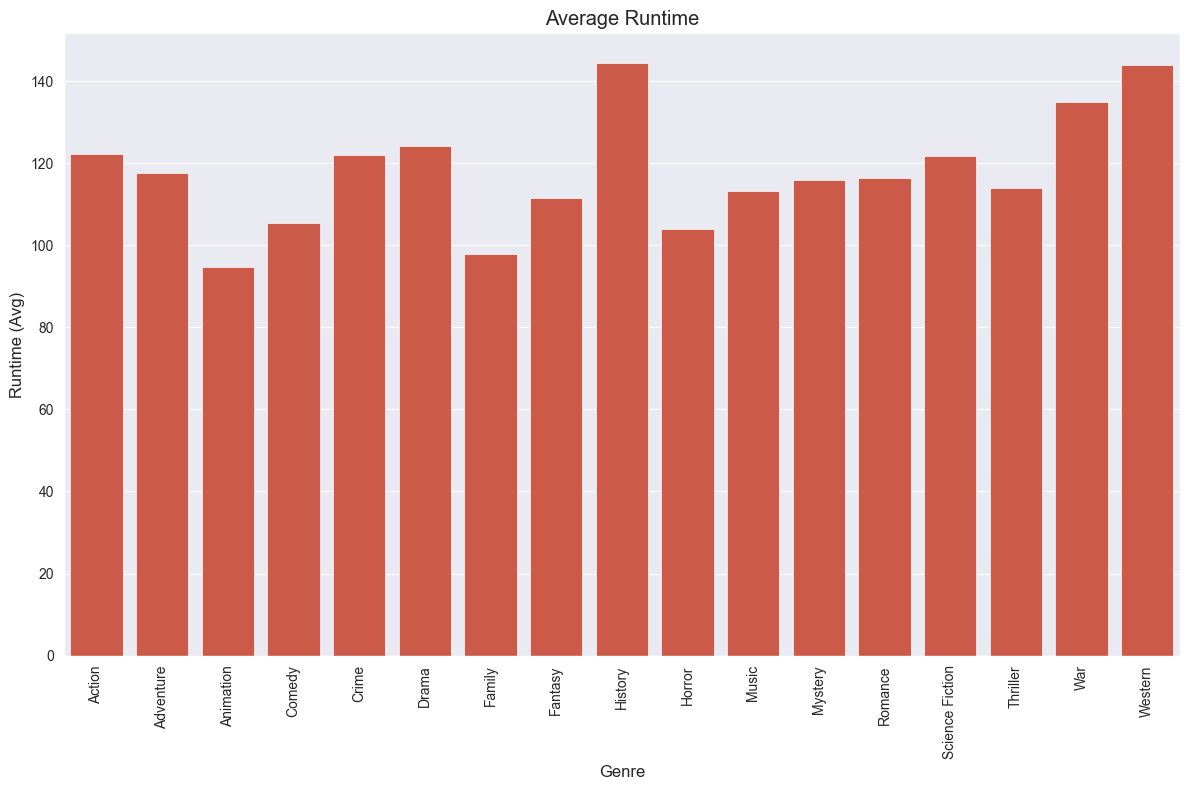

In [492]:
all_genres = [
    genre for sublist in processed_eda_df["genre"] for genre in sublist
]
all_genres

genres_data = {
    "Genre": all_genres,
    "Revenue (mil)": processed_eda_df["revenue(mil)"].repeat(
        processed_eda_df["genre"].str.len()
    ),
    "Title": processed_eda_df["title"].repeat(
        processed_eda_df["genre"].str.len()
    ),
    "Month": processed_eda_df["month"].repeat(
        processed_eda_df["genre"].str.len()
    ),
    'Runtime': processed_eda_df['runtime(min)'].repeat(
        processed_eda_df['genre'].str.len()
    )
}
genres_df = pd.DataFrame(genres_data).sort_values(by="Revenue (mil)", ascending=False).reset_index()
genre_avg_runtime =genres_df.groupby('Genre')['Runtime'].mean().reset_index(name='Runtime (Avg)')
sns.barplot(data=genre_avg_runtime, x='Genre', y='Runtime (Avg)')
plt.title('Average Runtime')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

1. **Historical Movies Have the Longest Runtime**: The genres "History" and "Western" stand out with the longest average runtimes, both exceeding 140 minutes. This could be due to the detailed narratives often required in these genres, where the storytelling involves complex historical events or expansive landscapes that necessitate longer runtimes.

2. **Animation and Horror Have Shorter Runtimes**: "Animation" and "Horror" are on the shorter side, with average runtimes around or below 100 minutes. This might be because these genres often target younger audiences or rely on concise, intense storytelling that doesn't require extended time.

3. **Consistent Runtimes Across Most Genres**: Apart from the extremes, most other genres like "Action," "Drama," "Fantasy," and "Science Fiction" have fairly consistent average runtimes, typically ranging between 110 to 130 minutes. This consistency suggests that films in these genres tend to follow a similar structural format in terms of storytelling.

4. **Runtime Reflects Genre Expectations**: The variation in runtimes reflects genre expectations—historical and war films tend to be longer due to their narrative depth, while more straightforward genres like comedy or horror keep audiences engaged without overstaying their welcome.

These insights can help understand how movie length correlates with genre, potentially informing decisions in film production, marketing, and distribution.

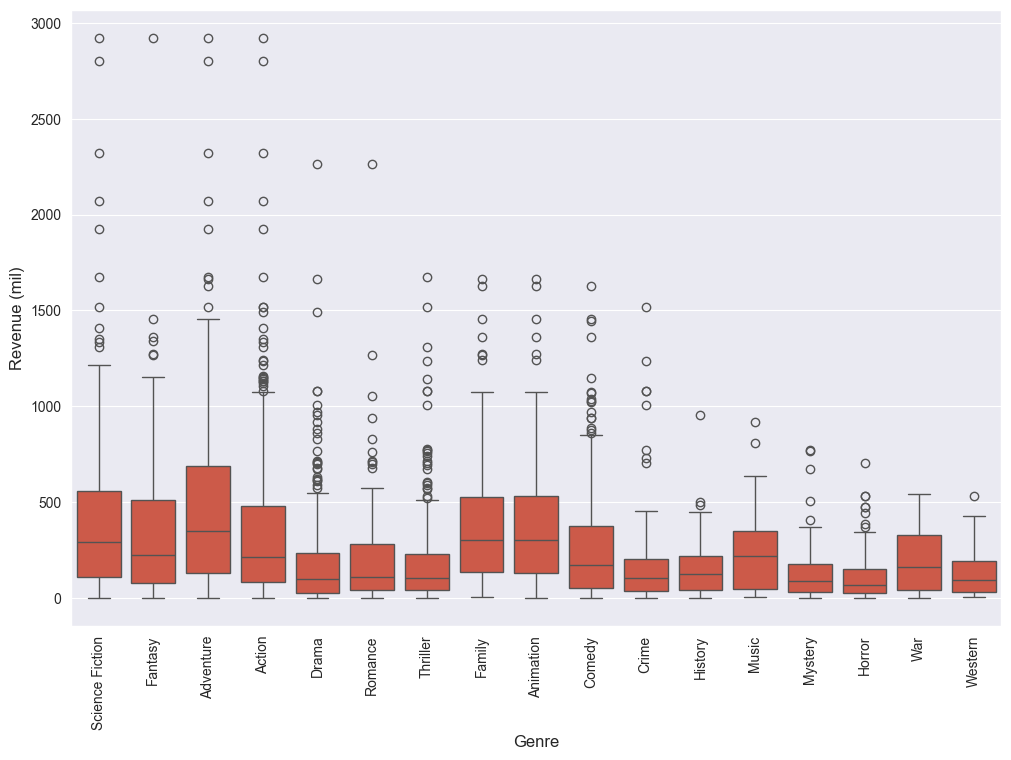

In [498]:
sns.boxplot(genres_df[['Genre', 'Revenue (mil)']], x='Genre', y='Revenue (mil)')
plt.xticks(rotation=90)
plt.show()

## Conclusion and Insights:

Through the exploratory data analysis (EDA) conducted on the movie dataset, several key insights have been unearthed, shedding light on various aspects of the movie industry. Here's a summary of the findings:

- **Seasonal Trends:** Analysis of movie release dates revealed distinct spikes in certain months, correlating with holidays and seasonal changes. This suggests that production companies strategically time their movie releases to capitalize on heightened audience engagement during these periods.

- **Popularity Over Time:** A notable spike in movie popularity around 2024 was observed, indicating a significant increase in audience interest during that period. Further investigation into external factors influencing this spike could provide valuable insights.

- **Movie Runtimes:** The distribution of movie runtimes highlighted a peak between 100 and 120 minutes, reflecting audience preferences for movies within this duration range.

- **Genre Preferences:** Analysis of movie genres revealed 'Action' as the most prevalent genre, followed by 'Adventure' and 'Drama'. However, the revenue analysis showed that 'Adventure' movies tend to generate the highest revenue, indicating a potential discrepancy between popularity and financial performance.

- **Production Companies:** Top production companies such as 'Warner Bros', 'Columbia Pictures', and 'Universal Pictures' were identified based on the number of movies produced. Further analysis revealed their revenue and budget dynamics, offering insights into their financial performance and investment strategies.


## Future Direction:

Building upon these insights, the next step would involve leveraging machine learning techniques to predict movie revenue. By analyzing various features such as genre, production budget, release date, and more, predictive models can be developed to forecast revenue potential for upcoming movies.

This predictive capability would not only assist production companies in making informed decisions regarding resource allocation and investment but also provide valuable insights into audience preferences and market trends.

In conclusion, the combination of exploratory data analysis and machine learning holds immense potential for empowering stakeholders in the movie industry to navigate the complex landscape of movie production and distribution effectively.

# Model PreProcessing 

In [464]:
model_df = processed_eda_df.copy()

In [465]:
top_by_rev_pc = processed_eda_df.sort_values(by='revenue(mil)', ascending=False).iloc[:10]['production_companies']

In [466]:
production_companies = set([
    company
    for sublist in top_by_rev_pc
    for company in sublist
])

In [467]:
bool_dict = {}
for col in production_companies:
    bool_col = []
    for sublist in model_df['production_companies']:
        if col in sublist:
            bool_col.append(1)
        else:
            bool_col.append(0)
    bool_dict[col] = bool_col
bool_df = pd.DataFrame(bool_dict)
model_df = pd.concat([model_df.reset_index(), bool_df.reset_index()], axis=1,)

In [468]:
unique_genre = set(genres)

In [469]:
model_df.fillna(method='ffill', inplace=True)

In [470]:
from sklearn.model_selection import train_test_split

X_cols = model_df.drop(columns="revenue(mil)", axis=1)
y_cols = model_df["revenue(mil)"]
X_train, X_test, y_train, y_test = train_test_split(
    X_cols, y_cols, shuffle=True, test_size=0.2, random_state=42
)

In [471]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class DateTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()
        X["year"] = X["release_date"].dt.year

        X["month"] = X["release_date"].dt.strftime("%b")
        matrix = encoder.fit_transform(X[["month"]]).toarray()
        columns_names = [
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ]
        for i in range(len(matrix.T)):
            X[columns_names[i]] = matrix.T[i]

        X["day"] = X["release_date"].dt.strftime("%a")
        weekend = ["Sat", "Sun"]
        X["day"] = X["day"].apply(lambda x: "Weekend" if x in weekend else "Weekday")
        matrix = encoder.fit_transform(X[["day"]]).toarray()
        columns_names = ["Weekend", "Weekday"]
        for i in range(len(matrix.T)):
            X[columns_names[i]] = matrix.T[i]

        return X

In [472]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["adult"] = X["adult"].map({True: 1, False: 0})
        X.columns = X.columns.astype("str")
        X = X.rename(str, axis="columns")
        return X

In [473]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(
            columns=[
                "production_companies",
                "production_countries",
                "genre",
                "original_language",
                "release_date",
                'index',
                "year",
                "adult",
                "title",
                "month",
                "day",
            ]
        )

In [474]:
from sklearn.pipeline import Pipeline

ml_pipeline = Pipeline(
    [
        ("date_Transformer", DateTransformer()),
        ("encoder", FeatureEncoder()),
        ("dropper", FeatureDropper()),
    ]
)

In [475]:
processed_X_train = ml_pipeline.fit_transform(X_train)

In [476]:
processed_X_train.columns

Index(['popularity', 'budget(mil)', 'runtime(min)', 'Paramount Pictures',
       'Lightstorm Entertainment', 'Universal Pictures', 'Marvel Studios',
       '20th Century Studios', 'Amblin Entertainment', 'Columbia Pictures',
       'Walt Disney Pictures', 'Dune Entertainment', 'Fairview Entertainment',
       'Lucasfilm Ltd.', 'Pixar', 'Pascal Pictures', '20th Century Fox',
       'Ingenious Media', 'Bad Robot', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Weekend', 'Weekday'],
      dtype='object')

In [477]:
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, Ridge


model = LinearRegression()
model.fit(processed_X_train, y_train)

LinearRegression()

In [478]:
processed_X_test = ml_pipeline.fit_transform(X_test)

In [479]:
processed_X_test.columns

Index(['popularity', 'budget(mil)', 'runtime(min)', 'Paramount Pictures',
       'Lightstorm Entertainment', 'Universal Pictures', 'Marvel Studios',
       '20th Century Studios', 'Amblin Entertainment', 'Columbia Pictures',
       'Walt Disney Pictures', 'Dune Entertainment', 'Fairview Entertainment',
       'Lucasfilm Ltd.', 'Pixar', 'Pascal Pictures', '20th Century Fox',
       'Ingenious Media', 'Bad Robot', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Weekend', 'Weekday'],
      dtype='object')

In [480]:
model.score(processed_X_test, y_test)

0.5045269187500256

In [481]:
from sklearn.metrics import r2_score, mean_absolute_error

In [482]:
y_pred = model.predict(processed_X_test)

In [483]:
r2_score(y_test, y_pred)

0.5045269187500256

In [484]:
mean_absolute_error(y_test, y_pred)

150.38250294978573